<a href="https://colab.research.google.com/github/FHnt97/TOM_Thesis/blob/main/WESAD_Debiasing_Classification_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debiasing classification algorithms for Occupational Stress Detection


---


## Content:
Find an introduction to the aim and dataset in the README file.


- **Dataset**
    - WESAD dataset
    - **Sensitve attributes**: age (non binary attribute) & gender (binary attribute)
    - Unbalanced representation of groups in sample (sample size disparity)

- **Domain**
    - Operations management - stress detection 

- **ML task**
    - SMV (rbf)
    - LinearClassifier (log)
    - K-NN     

- **Fairness tasks**
    - Assessment of unfairness 
    - Mitigation of unfairness with a focus on equal **FALSE NEGATIVE RATE** and **SELECTION RATE**

- **Model performance metrics**:
    - Confusion matrix
    - Recall, accuracy & precision
    - ROC curves

- **Model fairness metrics**:
    - Equalized odds / False negatives and False negative rate [link](https://fairware.cs.umass.edu/papers/Verma.pdf)
    - Selection Rate

- **Mitigation algorithms**:

*The objective is to reduce false negatives / make them equal (avoid burnout of employees)*

        - Reweighting (aif360 - preprocessing)
        - Exponential gradient (fairlearn - postprocessing)
        - ThresholdOptimizer (fairlearn - postprocessing)





```
    C=c(x, A) = c(X)
```



> HOWEVER: in Operations management, and especially in the measure of fatigue, physiological data is used for each participant; this can act as a proxy to the sensitive attribute. 


> NOTE: an FN means that someone who's stressed was not identified and therefore received no support -- if stress/ fatigue is NOT detected when present, it can lead to dangerous situations for employees/ burnouts in the long term 





```
# Nomeclature: 

X ∈ Rᵈ: quantified features of the applicant

A ∈ {0, 1}: binary sensitive attribute gender

C :=c(X,A) ∈ {0,1}: binary predictor (stressed vs. ok), which makes decision based on a score R:=r(x, a) ∈ [0,1]

Y ∈ {0, 1}: target variable

```


For ths final representation of the model a **MODEL CARD** will be presented. 


## BASE CODE

### Libraries

In [1]:
# importing general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import Markdown, display

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
! pip install fairlearn
! pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 3.7 MB/s 
     |████████████████████████████████| 569 kB 38.0 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=7a85836761a6519902c443e427c5565e92b0ae9a935fc0bd630e7d90615f498f
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


### Data load and wrangling

In [176]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
# open csv historical data
# if using collab use -->
path = '/content/drive/MyDrive/00 - thesis/Thesis - Fabia Höhne/Datasets/WESAD/m14_merged.csv'

# if using the GitHub repo use -->
# path = './Datasets/WESAD/m14_merged.csv'

df = pd.read_csv(path, sep=',', index_col=0)

In [178]:
# reorder df columns & remove features which will not be used (lifestyle features, 3D data)
# remove min, max values, as mean & st. dev are already calculated
# remove according to corr analysis --> total of 18 attributes left 

cols = ['subject', 'label', 
        'age','gender_ female',
        'height', 'weight', 
        'BVP_std', 
        'EDA_mean', 'EDA_std', 
        'EDA_phasic_mean','EDA_phasic_std', 
        'EDA_smna_mean','EDA_smna_std', 
        'EDA_tonic_mean','EDA_tonic_std',  
        'Resp_std', 
        'TEMP_mean', 'TEMP_slope']

df = df[cols]


In [179]:
# rename gender (male:0, female:1)
df = df.rename(columns = {'gender_ female':'gender'})

In [180]:
# remove amusement state 
# 1: baseline, 2: stressed
df = df.loc[~(df['label'] == 0)]

In [181]:
# chang 1,2 classification to 0,1 classification to avoid problems down the line
# 0: baseline, 1: stressed
df['label'] = df['label'].replace({1: 0})
df['label'] = df['label'].replace({2: 1})

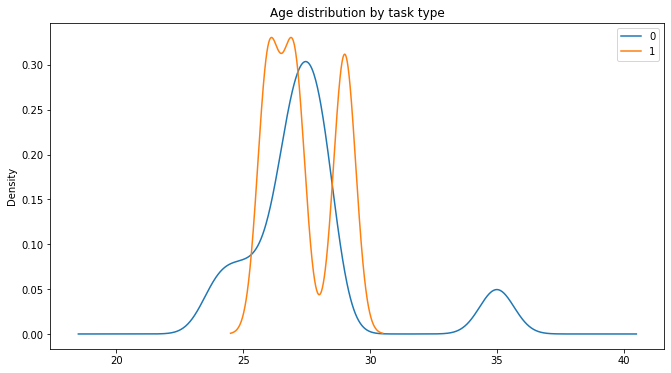

In [182]:
# check gender & age representation 
fig, ax = plt.subplots(figsize=(11, 6))
ax.set_title('Age distribution by task type')
df.groupby('gender').age.plot(kind='kde')
ax.legend()

In [183]:
# bin age into groups to noramlize
def custom_round(x, base):
    return base * round(float(x)/5)

df['age'] = df.age.apply(lambda x: custom_round(x, 5))

In [184]:
# check for correctness 
df.head()

,subject,label,age,gender,height,weight,BVP_std,EDA_mean,EDA_std,EDA_phasic_mean,EDA_phasic_std,EDA_smna_mean,EDA_smna_std,EDA_tonic_mean,EDA_tonic_std,Resp_std,TEMP_mean,TEMP_slope
0,2,0,25,0,175,80,107.648359,1.397968,0.141481,1.824289,1.088328,1.284376,1.952823,1.232164,0.997487,2.935617,35.817091,-0.000169
1,2,0,25,0,175,80,118.742089,1.210132,0.091882,2.109146,1.223528,1.467865,2.852510,0.377615,1.172221,2.843123,35.797568,-0.000789
2,2,0,25,0,175,80,42.190039,1.010977,0.102315,0.152828,0.128896,0.105091,0.244891,1.727696,0.293389,1.700333,35.712909,-0.000717
3,2,0,25,0,175,80,41.606872,0.775187,0.046391,0.177595,0.126167,0.110786,0.199704,0.987927,0.042388,1.483260,35.700811,0.000075
4,2,0,25,0,175,80,43.121633,0.657494,0.034540,0.035014,0.039616,0.026716,0.114738,0.772262,0.077628,1.501585,35.744727,0.000442


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 1164
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject          983 non-null    int64  
 1   label            983 non-null    int64  
 2   age              983 non-null    int64  
 3   gender           983 non-null    int64  
 4   height           983 non-null    int64  
 5   weight           983 non-null    int64  
 6   BVP_std          983 non-null    float64
 7   EDA_mean         983 non-null    float64
 8   EDA_std          983 non-null    float64
 9   EDA_phasic_mean  983 non-null    float64
 10  EDA_phasic_std   983 non-null    float64
 11  EDA_smna_mean    983 non-null    float64
 12  EDA_smna_std     983 non-null    float64
 13  EDA_tonic_mean   983 non-null    float64
 14  EDA_tonic_std    983 non-null    float64
 15  Resp_std         983 non-null    float64
 16  TEMP_mean        983 non-null    float64
 17  TEMP_slope     

### Exploratory Analysis

---


We see that there is a clear underrepresentation of women, and peple over 30.

Furthermore, there is a strong correlation between gender & weight/ height. We therefore consider these attributes as a proxy to the sensitve attribute. These attributes will be removed from the equation to allow for unaware training.  

We also see:
- BVP & Resp EDA st.dev. correlatin with age 
- Temp correlation with age & gender


In [13]:
# check for sample distributions
# count subjects by gender, age, label
df.groupby(["gender"])['gender'].count()/66 # on avg. each subject has 66 entries

gender
0    11.863636
1     3.030303
Name: gender, dtype: float64

In [14]:
df.groupby(["age"])['age'].count()/66

age
25    8.848485
30    5.045455
35    1.000000
Name: age, dtype: float64

In [15]:
df['label'].value_counts()

0    628
1    355
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


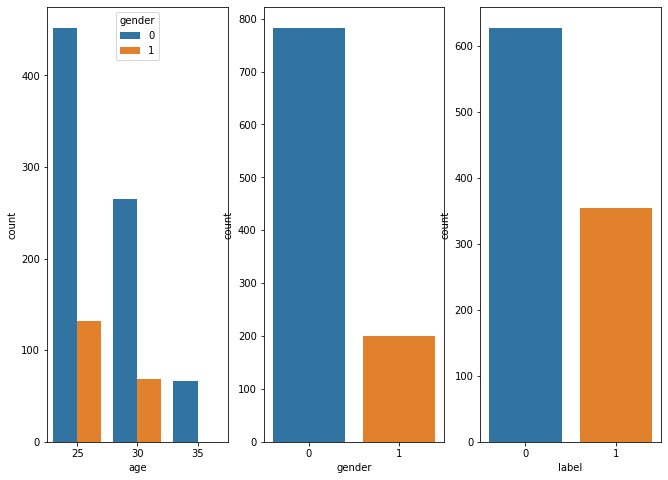

In [16]:
# plot sample distributions
fig, ax = plt.subplots(1,3)
fig.set_size_inches(11, 8)
sns.countplot(df['age'], ax=ax[0], hue=df.gender)
sns.countplot(df['gender'], ax=ax[1])
sns.countplot(df['label'], ax=ax[2])  ## label 
fig.show()

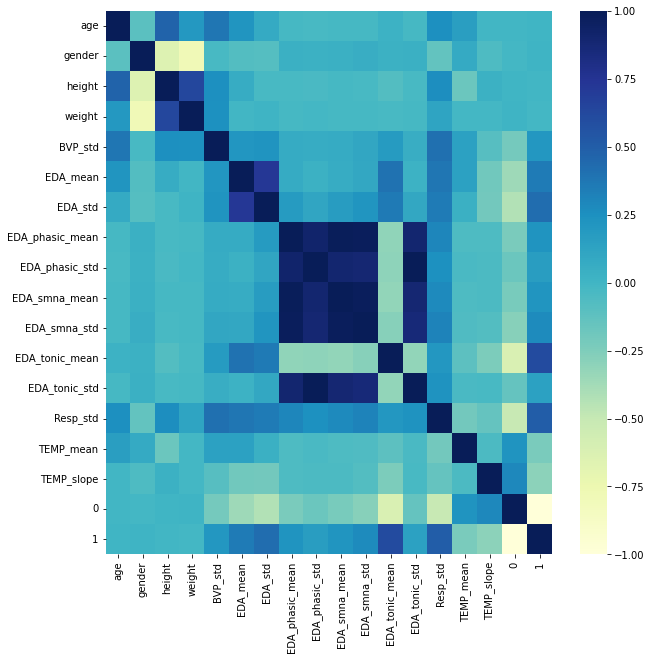

In [17]:
# correlation analysis 
df_corr = pd.concat([df.drop('label', axis=1), pd.get_dummies(df['label'])], axis=1)
df_corr = df_corr.drop('subject', axis =1 )
corr = df_corr.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap="YlGnBu");

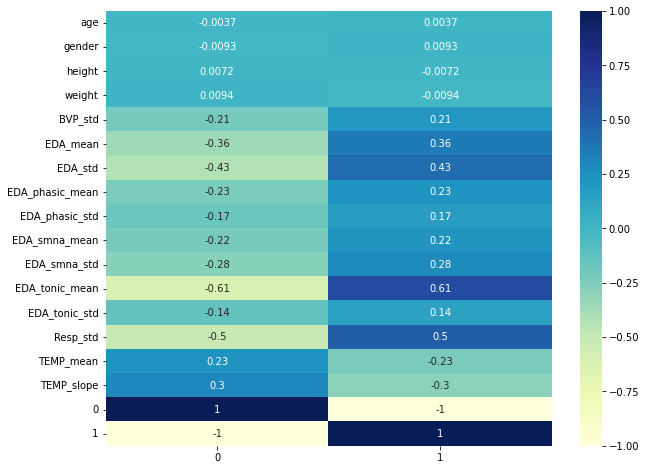

In [18]:
feats = df.columns[1:]

df_corr = pd.concat([df[feats].drop('label', axis=1), pd.get_dummies(df[feats]['label'])], axis=1)
corr = df_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[[0, 1]], annot=True, cmap="YlGnBu")

<Figure size 720x720 with 0 Axes>

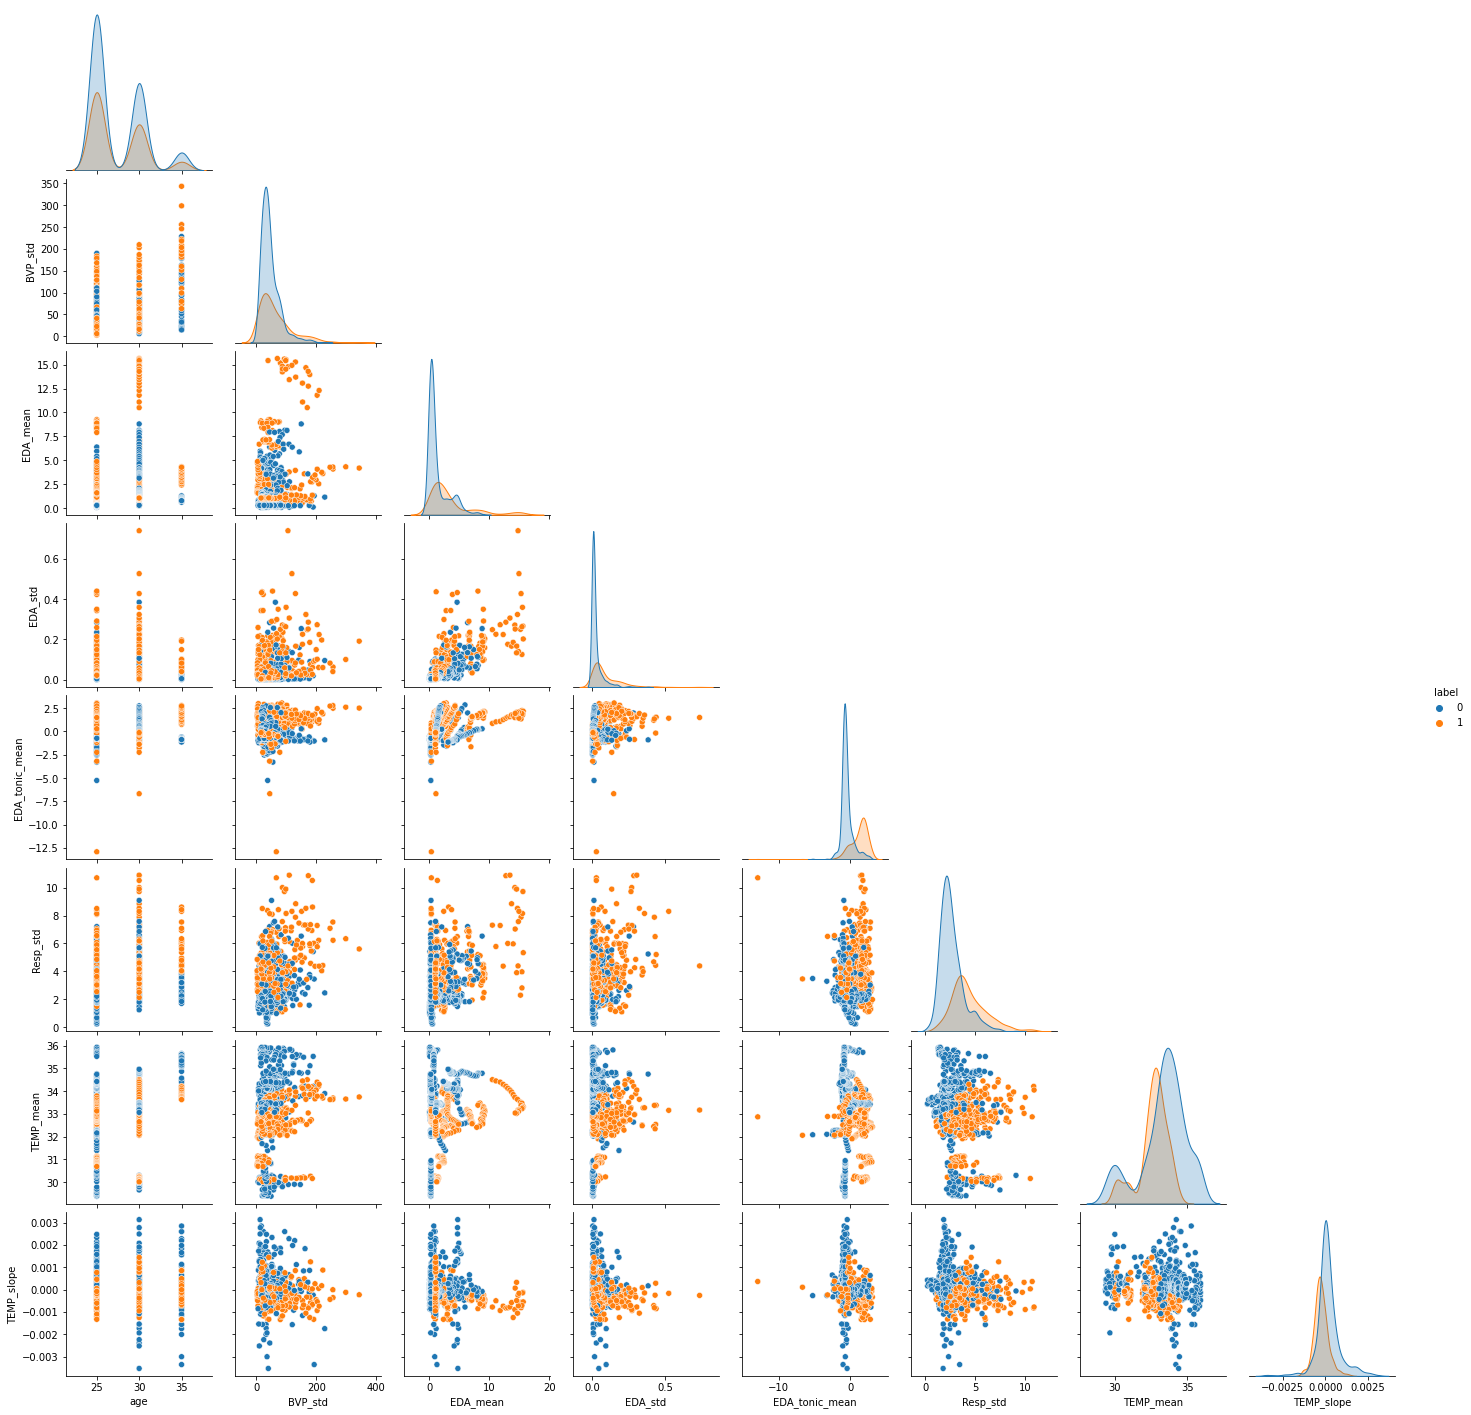

<Figure size 720x720 with 0 Axes>

In [19]:
# to avoid logn processing times, load only most relevant data for pairplot
# check for any anomalies/ trends in correlaitons between attributes
cols2 = ['age','label', 
        'BVP_std', 
        'EDA_mean', 'EDA_std',  
        'EDA_tonic_mean',  
        'Resp_std', 
        'TEMP_mean', 'TEMP_slope']


sns.pairplot(df[cols2], hue="label", corner=True)
plt.figure(figsize=(10,10))

## Stress Model
-----


 [Stweard et al. (2020)](https://arxiv.org/pdf/2002.04176.pdf) use the following models to obtain a best- possible generic model for this dataset to detect stress:

- svm (gamma 0.0526) 
- log regression (11 penalization, c=1)
- k-nn (n=20)


#### libraries and helper functions

In [20]:
# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier



# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)

In [112]:
# Helper functions metrics
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
                "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        " ------": (lambda x: "", True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate},
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group


def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})

### Models set-up: test/train split

In [186]:
# simple model - aware (inlc. proxies)
# set test & train data & defining age as sensitive attribute

X = df.drop(columns=['label'])
y = df['label']

A = df[['age', 'gender']]
Gender_str = A['gender'].map({ 1:"female", 0:"male"})

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, Gender_str_train, Gender_str_test = train_test_split(
    X, 
    y, 
    A, 
    Gender_str,
    test_size = 0.33, 
    random_state=42)

### Model set-up & definition

In [187]:
# set up model:
classifiers = [LogisticRegression(C=1),
               SVC(kernel='rbf', gamma = 0.0526, probability = True),
               KNeighborsClassifier(n_neighbors=20),]


### Model performance evaluation

##### Confusion matrix (test/ train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the cl

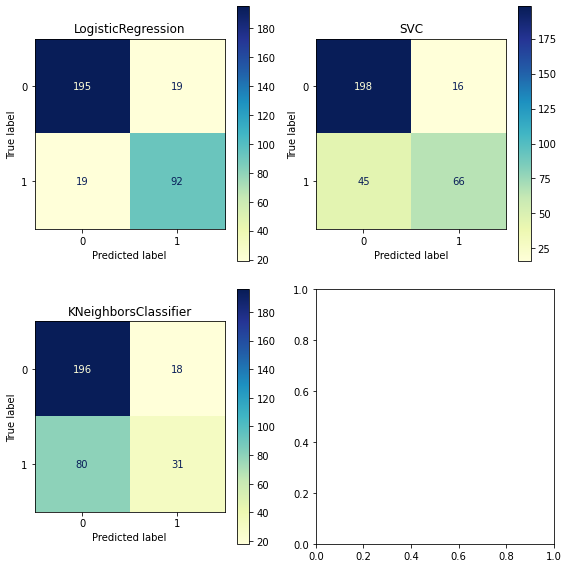

In [188]:
# test set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the cl

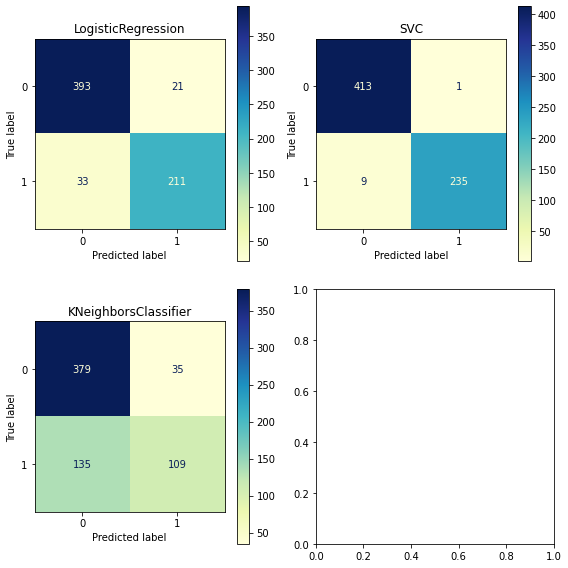

In [189]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

##### Cross Validation

In [190]:
# train model, get accuracies and CV
groups = X_test['subject']
gkf = GroupKFold(n_splits=4)

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  scores = cross_val_score(model, X_test, y_test, cv=gkf, groups=groups, scoring='accuracy')
  print (f'{model}  {chr(10)} CV: {scores.mean()} {chr(10)}')

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

LogisticRegression(C=1)  
 CV: 0.8380029650713094 

SVC(gamma=0.0526, probability=True)  
 CV: 0.6634223998141532 

KNeighborsClassifier(n_neighbors=20)  
 CV: 0.6879769663154011 



##### Classification report

In [147]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f'{model}: {chr(10)} {classification_report(y_test, y_pred)}')

LogisticRegression(C=1): 
               precision    recall  f1-score   support

           0       0.92      0.91      0.92       214
           1       0.83      0.86      0.84       111

    accuracy                           0.89       325
   macro avg       0.87      0.88      0.88       325
weighted avg       0.89      0.89      0.89       325



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


SVC(gamma=0.0526, probability=True): 
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       214
           1       0.76      0.77      0.76       111

    accuracy                           0.84       325
   macro avg       0.82      0.82      0.82       325
weighted avg       0.84      0.84      0.84       325

KNeighborsClassifier(n_neighbors=20): 
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       214
           1       0.73      0.40      0.51       111

    accuracy                           0.74       325
   macro avg       0.74      0.66      0.67       325
weighted avg       0.74      0.74      0.72       325



##### Precision recall

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


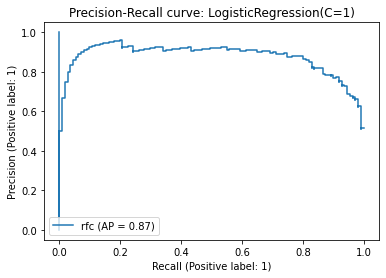

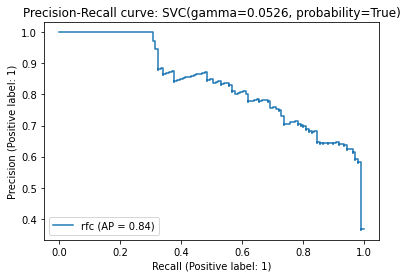

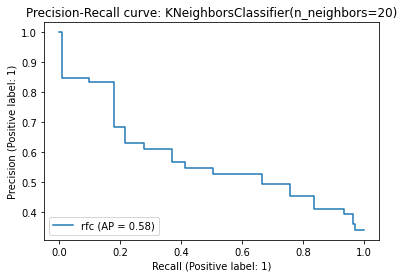

In [191]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')

### Model fairness evaluation

##### Metric Frames

In [192]:
# define sensitive attributes
gender = A_test['gender']
age =  A_test['age']


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Age:{chr(10)}{model}: {chr(10)} {metric_frame (age)} {chr(10)}')
  print(f'Gender:{chr(10)}{model}: {chr(10)} {metric_frame (gender)} {chr(10)}')

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


Age:
LogisticRegression(C=1): 
           FPR       FNR       TPR       TNR
age                                        
25   0.133333  0.044118  0.955882  0.866667
30    0.12987  0.333333  0.666667   0.87013
35        0.0       0.0       1.0       1.0 

Gender:
LogisticRegression(C=1): 
              FPR       FNR       TPR       TNR
gender                                        
0        0.08427  0.012987  0.987013   0.91573
1       0.305556  0.411765  0.588235  0.694444 

Age:
SVC(gamma=0.0526, probability=True): 
           FPR       FNR       TPR       TNR
age                                        
25   0.116667  0.205882  0.794118  0.883333
30   0.272727  0.111111  0.888889  0.727273
35   0.529412  0.142857  0.857143  0.470588 

Gender:
SVC(gamma=0.0526, probability=True): 
              FPR       FNR       TPR       TNR
gender                                        
0       0.219101  0.116883  0.883117  0.780899
1       0.138889  0.294118  0.705882  0.861111 

Age:
KNeighborsCla

You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


##### Fairness metrics by group (equalized odds, demographic parity difference & ratio, false negative rate difference)

In [193]:
# Metrics 
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}')

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Age:
LogisticRegression(C=1): 
                                Unmitigated
Equalized_odds_difference         0.333333
False negative rate difference    0.333333
 ------                                   
Demographic parity difference     0.139184
Balanced error rate difference    0.231602
  ------                                  
Overall AUC                       0.949608
AUC difference                    0.087662 

Age:
SVC(gamma=0.0526, probability=True): 
                                Unmitigated
Equalized_odds_difference         0.412745
False negative rate difference    0.080065
 ------                                   
Demographic parity difference     0.257979
Balanced error rate difference    0.182213
  ------                                  
Overall AUC                       0.905637
AUC difference                    0.043596 

Age:
KNeighborsClassifier(n_neighbors=20): 
                                Unmitigated
Equalized_odds_difference         0.384921
False negative 

In [194]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Gender:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, gender)} {chr(10)}')

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Gender:
LogisticRegression(C=1): 
                                Unmitigated
Equalized_odds_difference         0.398778
False negative rate difference    0.398778
 ------                                   
Demographic parity difference     0.085994
Balanced error rate difference    0.310032
  ------                                  
Overall AUC                       0.949608
AUC difference                    0.192047 

Gender:
SVC(gamma=0.0526, probability=True): 
                                Unmitigated
Equalized_odds_difference         0.177235
False negative rate difference    0.177235
 ------                                   
Demographic parity difference     0.005322
Balanced error rate difference    0.048511
  ------                                  
Overall AUC                       0.905574
AUC difference                     0.02696 

Gender:
KNeighborsClassifier(n_neighbors=20): 
                                Unmitigated
Equalized_odds_difference         0.258427
False 

##### visualisation help

In [199]:
# demographic disparity
# https://github.com/fairlearn/fairlearn/blob/main/notebooks/Mitigating%20Disparities%20in%20Ranking%20from%20Binary%20Data.ipynb

from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 3 ### change to 4/2 depending on the sensitive attribute (Age vs. task)
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

#### visualisation

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


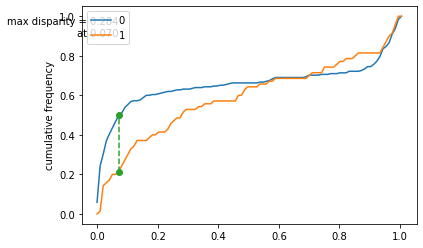

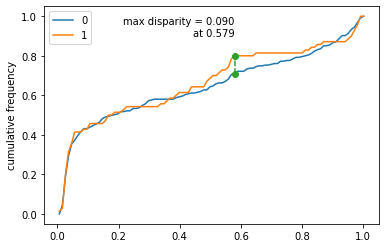

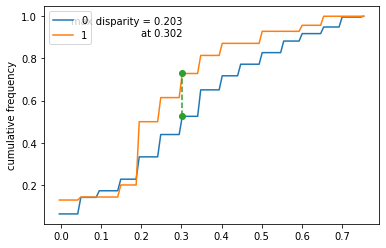

In [197]:
%matplotlib inline

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1


  display(HTML('<span id="disparity_unmitigated">'))
  plot_and_compare_cdfs(y_pred, gender)
  display(HTML('</span>'))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


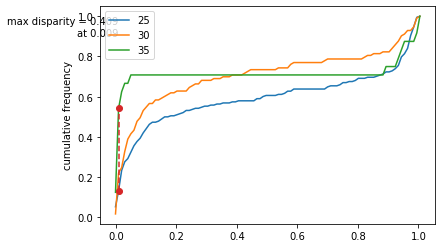

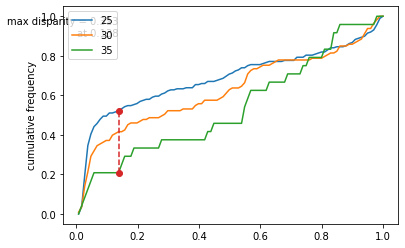

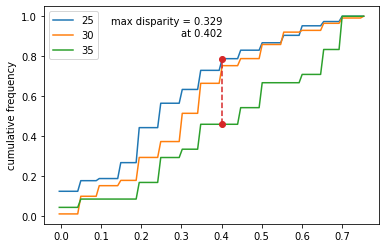

In [200]:
%matplotlib inline

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1


  display(HTML('<span id="disparity_unmitigated">'))
  plot_and_compare_cdfs(y_pred, age)
  display(HTML('</span>'))

# Debiasing the model

---




Are we minitating bias (removing the problematic signal) - OR adding inclusion (add singal for deasired features for a re-weighted singal improved fairness?


Bias can come from the acutal data or the algorithm (this includes technical bias from data processing & amplified bias from the feedback loops)



pre-processing: suprression, class relabeling, reweighing, data transportation, database reparis, data augmentation


#### libraries and functions

In [41]:
import aif360

from aif360.datasets import StandardDataset
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover

# fairlearn libraries
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

from fairlearn.reductions import (ExponentiatedGradient, 
                                  EqualizedOdds, 
                                  TruePositiveRateParity,
                                  GridSearch)

#### 1. Reweigh samples for age (AIF360)

Based on:
1. [Correcting Unfair Binary Classification
Models](http://arno.uvt.nl/show.cgi?fid=157880)

2. [AIF360 example](https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb)


In [206]:
# works only for SVM & log reg (knn doesnt do sample weights)
classifiers = [LogisticRegression(C=1),
               SVC(kernel='rbf', gamma = 0.0526, probability = True)]

# set dataset in aif360 format
ds_aif = aif360.datasets.StandardDataset (df, 
                                         label_name="label",
                                         favorable_classes = [1], 
                                         protected_attribute_names=['gender', 'age'], 
                                         privileged_classes= [lambda x: x == 0],
                                         features_to_drop=['subject'])

In [207]:
# test, train split
ds_train, ds_test = ds_aif.split([0.67], shuffle=True)

In [208]:
# pre-processing - reweighing 
# define priviledged & unpriviledged groups
unpriv = [{'gender': 1}]
priv = [{'gender': 0}]

# reweigh
RW = Reweighing (unprivileged_groups = unpriv, 
                 privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

In [209]:
# check for metric before and after transforming 
# OG ds
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

# transpormed ds
metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)


# metrics
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train.mean_difference())
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())


display(Markdown("#### Disparate impact"))
print(f'Before reweighing {explainer_train.disparate_impact()}')
print(f'After reweighing {explainer_transf_train.disparate_impact()}')

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.021618


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


#### Disparate impact

Before reweighing Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.063013027320619
After reweighing Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999996


In [211]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()

###### evaluations

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


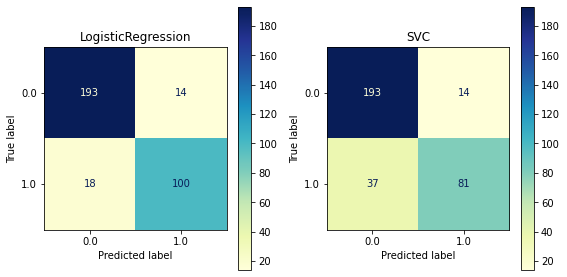

In [212]:
# test models with reweighted data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)

plt.tight_layout()
plt.show()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


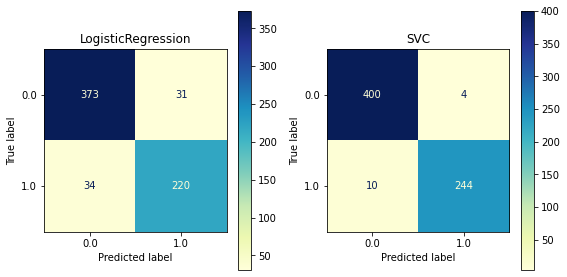

In [163]:
# double check with train set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = w_train)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [213]:
for cls in classifiers:
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = w_train)
  y_pred = cls.predict(X_test)
  
  print(f'{cls}: {chr(10)} {classification_report(y_test, y_pred)}')

LogisticRegression(C=1): 
               precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       207
         1.0       0.88      0.85      0.86       118

    accuracy                           0.90       325
   macro avg       0.90      0.89      0.89       325
weighted avg       0.90      0.90      0.90       325

SVC(gamma=0.0526, probability=True): 
               precision    recall  f1-score   support

         0.0       0.84      0.93      0.88       207
         1.0       0.85      0.69      0.76       118

    accuracy                           0.84       325
   macro avg       0.85      0.81      0.82       325
weighted avg       0.84      0.84      0.84       325



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


###### fairness evaluations

In [214]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

In [216]:
for cls in classifiers:
  dataset = RW_train
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  # scores on test set
  ds_test_pred.scores = cls.predict_proba(X_test)[:1]

  # predictions (0 or 1) on test set
  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"mitigated": (test_preds, y_pred)}

  print(f'Gender:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, gender)} {chr(10)}') # change age<> gender
  print(f'Gender:{chr(10)}{cls}: {chr(10)} {metric_frame (gender)} {chr(10)}') # change age<> gender

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


Gender:
LogisticRegression(C=1): 
                                mitigated
Equalized_odds_difference        0.16172
False negative rate difference   0.16172
 ------                                 
Demographic parity difference   0.082913
Balanced error rate difference  0.066045
  ------                                
Overall AUC                     0.889912
AUC difference                  0.066045 

Gender:
LogisticRegression(C=1): 
              FPR      FNR      TPR       TNR
gender                                      
0       0.074074  0.11828  0.88172  0.925926
1       0.044444     0.28     0.72  0.955556 

Gender:
SVC(gamma=0.0526, probability=True): 
                                mitigated
Equalized_odds_difference       0.058925
False negative rate difference  0.058925
 ------                                 
Demographic parity difference   0.026611
Balanced error rate difference  0.028845
  ------                                
Overall AUC                     0.809404
AU

You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


#### Fair learn - post processign methods -- wrappers



In [247]:
# set test & train data & defining age as sensitive attribute - UNAWARE

X = df.drop(columns=['gender', 'age', 'label', 'height', 'weight'])
y = df['label']

# A = df[['gender']]
A = df[['age']]

# Gender_str = A['gender'].map({ 1:"female", 0:"male"})

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, Gender_str_train, Gender_str_test = train_test_split(
    X, 
    y, 
    A, 
    Gender_str,
    test_size = 0.33, 
    random_state=42)


In [231]:
metrics = {
    'accuracy': accuracy_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count}


metrics_dict = {
    'Equalized_odds_difference': equalized_odds_difference,
    'false_negative_rate_difference': false_negative_rate_difference,
    'Balanced error rate difference': balanced_accuracy_score}


classifiers = [LogisticRegression(C=1),
               SVC(kernel='rbf', gamma = 0.0526, probability = True),
               KNeighborsClassifier(n_neighbors=20),]

In [242]:
for cls in classifiers:
  unmitigated_pipeline = Pipeline(steps=[("model", cls)])

  unmitigated_pipeline.fit(X_train, y_train)

  y_pred = unmitigated_pipeline.predict(X_test)

  mf1 = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=y_pred,
                    sensitive_features=age)
  models_dict = {"Unmitigated": (test_preds, y_pred)}

# The disaggregated metrics are stored in a pandas Series mf1.by_group:
  print(f"{cls}:\n {mf1.by_group}\n")
  print(f"{cls} difference:\n {mf1.difference(method='between_groups')}\n")

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1):
      accuracy false positive rate false negative rate selection rate count
age                                                                       
25   0.914894            0.083333            0.088235       0.382979   188
30   0.823009            0.090909            0.361111       0.265487   113
35        1.0                 0.0                 0.0       0.291667    24

LogisticRegression(C=1) difference:
 accuracy               0.176991
false positive rate    0.090909
false negative rate    0.361111
selection rate         0.117492
count                       164
dtype: object

SVC(gamma=0.0526, probability=True):
      accuracy false positive rate false negative rate selection rate count
age                                                                       
25   0.882979               0.075            0.191176       0.340426   188
30   0.840708             0.12987            0.222222       0.336283   113
35      0.875            0.176471               

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


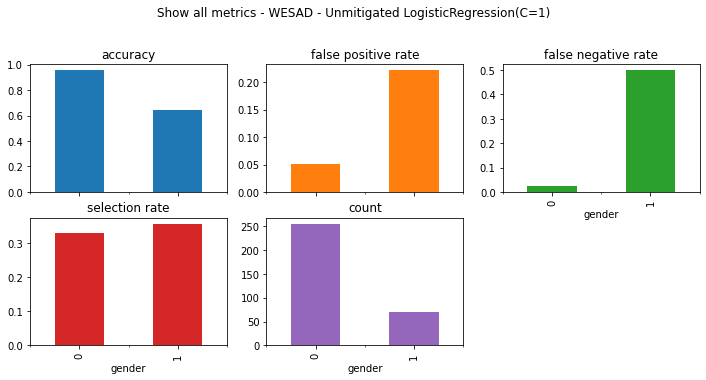

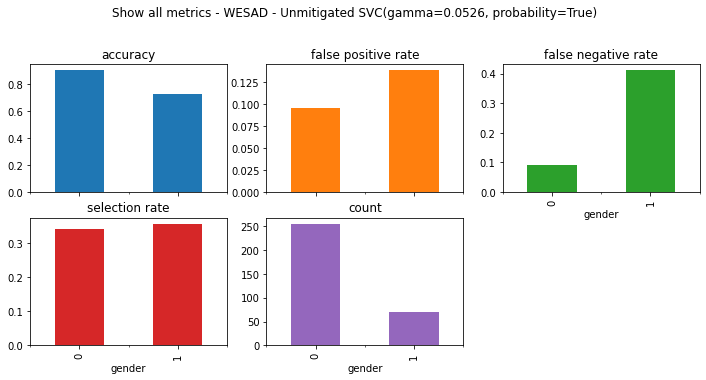

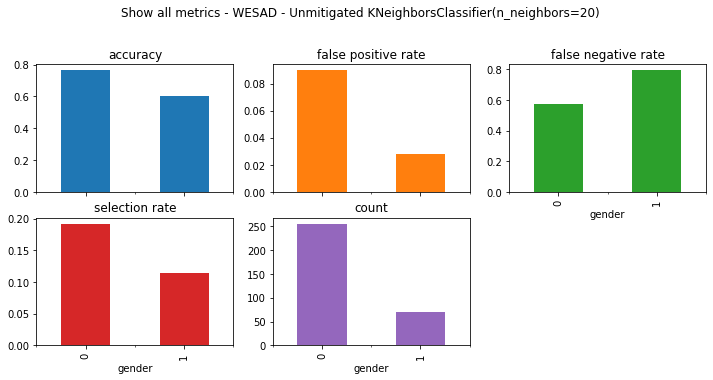

In [222]:
# visualize unmitigated
for cls in classifiers:
  unmitigated_pipeline = Pipeline(steps=[("model", cls)])

  unmitigated_pipeline.fit(X_train, y_train)

  y_pred = unmitigated_pipeline.predict(X_test) 

  mf2 = MetricFrame(metrics=metrics,
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=gender) # gender<>age

  # Customize plots with ylim
  mf2.by_group.plot(
      kind="bar",
  #    ylim=[0, 1],
      subplots=True,
      layout=[3, 3],
      legend=False,
      figsize=[12, 8],
      title=f'Show all metrics - WESAD - Unmitigated {cls}',
  )


#### 3. ExponentiatedGradient - reduction (fair learn)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to 

LogisticRegression(C=1) - Age:
     ExponentiatedGradient                                          \
                 accuracy false positive rate false negative rate   
age                                                                 
25                0.87234            0.133333            0.117647   
30                0.80531            0.220779            0.138889   
35                    1.0                 0.0                 0.0   

                          
    selection rate count  
age                       
25        0.404255   188  
30        0.424779   113  
35        0.291667    24  

LogisticRegression(C=1) difference:
 accuracy                0.19469
false positive rate    0.220779
false negative rate    0.138889
selection rate         0.133112
count                       164
dtype: object



Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Seri

SVC(gamma=0.0526, probability=True) - Age:
     ExponentiatedGradient                                          \
                 accuracy false positive rate false negative rate   
age                                                                 
25               0.888298            0.083333            0.161765   
30               0.884956             0.12987            0.083333   
35                  0.875            0.176471                 0.0   

                          
    selection rate count  
age                       
25        0.356383   188  
30        0.380531   113  
35        0.416667    24  

SVC(gamma=0.0526, probability=True) difference:
 accuracy               0.013298
false positive rate    0.093137
false negative rate    0.161765
selection rate         0.060284
count                       164
dtype: object



Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


TypeError: ignored

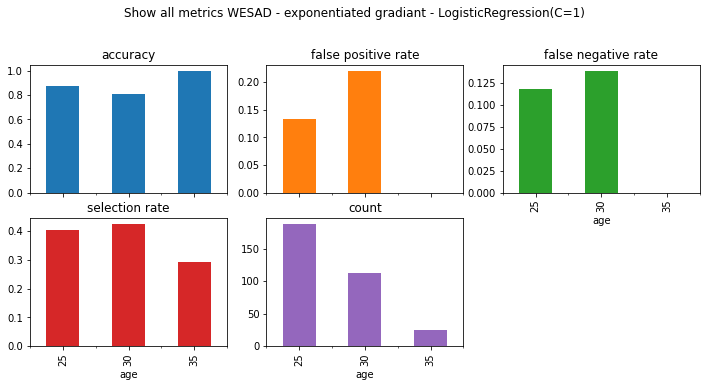

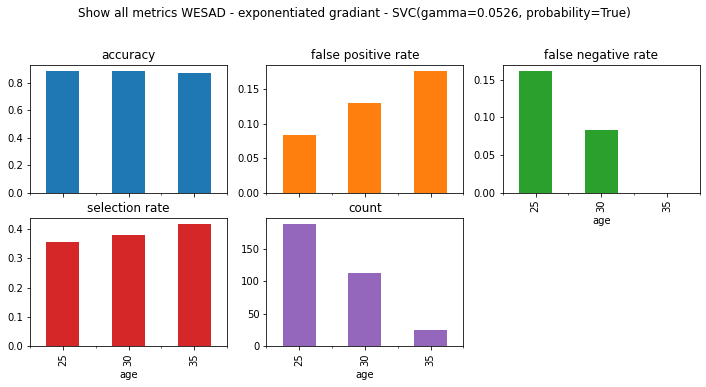

In [245]:
for cls in classifiers:
  expgrad_est = ExponentiatedGradient(estimator=cls,
                                    constraints=TruePositiveRateParity(difference_bound=0.07)) # for FNR 1-TPR
  
  expgrad_est.fit(X_train, y_train, sensitive_features=A_train)
  
  y_pred_reductions = expgrad_est.predict(X_test, random_state=42)
  
  mf_eg =  MetricFrame(metrics=metrics,
                                       y_true=y_test,
                                       y_pred=y_pred_reductions,
                                       sensitive_features=age) # gender<>age
  df_results = pd.concat([mf_eg.by_group],
                          keys=['ExponentiatedGradient'],
                          axis=1)
  
  print (f'{cls} - Age:{chr(10)} {df_results}{chr(10)}')
  print(f"{cls} difference:\n {mf_eg.difference(method='between_groups')}\n")

  # visualize mitigated
  mf_eg.by_group.plot(
      kind="bar",
  #    ylim=[0, 1],
      subplots=True,
      layout=[3, 3],
      legend=False,
      figsize=[12, 8],
      title=f'Show all metrics WESAD - exponentiated gradiant - {cls}',
  )



#### 4. Thresholdoptimizer (fair learn - post processing)

ThresholdOptimizer takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate thrceshold for each group in order to optimize some specified objective metric (such as balanced accuracy) subject to specified fairness constraints (such as false negative rate parity). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1):
     ThresholdOptimizer                                                         \
              accuracy false positive rate false negative rate selection rate   
age                                                                             
25            0.920213            0.083333            0.073529       0.388298   
30            0.823009            0.103896            0.333333       0.283186   
35            0.958333                 0.0            0.142857           0.25   

           
    count  
age        
25    188  
30    113  
35     24  

LogisticRegression(C=1) difference:
 accuracy               0.135324
false positive rate    0.103896
false negative rate    0.259804
selection rate         0.138298
count                       164
dtype: object

SVC(gamma=0.0526, probability=True):
     ThresholdOptimizer                                                         \
              accuracy false positive rate false negative rate selection rate   
ag

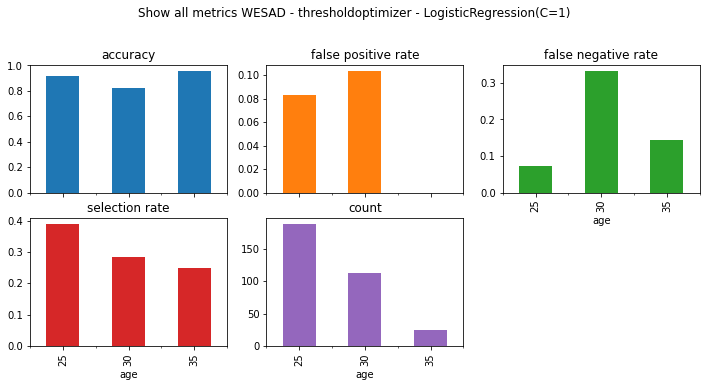

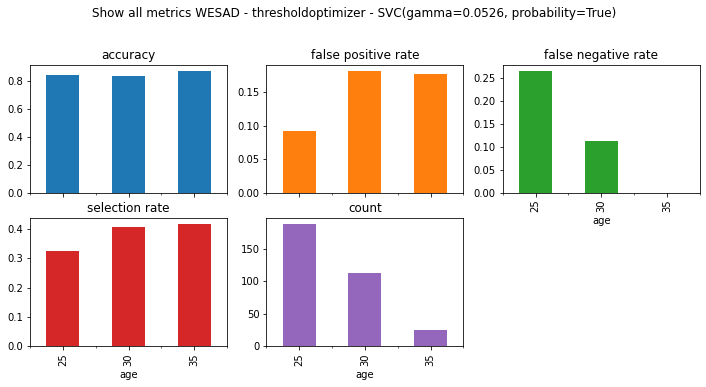

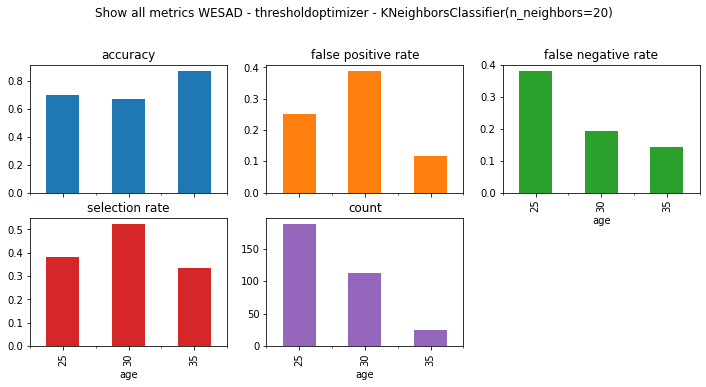

In [249]:
for cls in classifiers:
  unmitigated_pipeline = Pipeline(steps=[("model", cls)])

  unmitigated_pipeline.fit(X_train, y_train)
  
  postprocess_est = ThresholdOptimizer(estimator=unmitigated_pipeline,
                                       constraints="false_negative_rate_parity",
                                       objective="balanced_accuracy_score",
                                       prefit=True,
                                       predict_method='predict_proba')
  
  postprocess_est.fit(X_train, y_train, sensitive_features=A_train) # change a test in train/ test sample

  y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test) # gender<>age

  mf_to = MetricFrame(metrics=metrics,
                                        y_true=y_test,
                                        y_pred=y_pred_postprocess,
                                        sensitive_features=A_test) # gender<>age
  
  df_results = pd.concat([mf_to.by_group],
                          keys=['ThresholdOptimizer'],
                          axis=1)
  
  
  print (f'{cls}:{chr(10)} {df_results}{chr(10)}')
  print(f"{cls} difference:\n {mf_to.difference(method='between_groups')}\n")


  # visualize mitigated
  mf_to.by_group.plot(
      kind="bar",
  #    ylim=[0, 1],
      subplots=True,
      layout=[3, 3],
      legend=False,
      figsize=[12, 8],
      title=f'Show all metrics WESAD - thresholdoptimizer - {cls}',
  )


  

# AI fairness - summary and future considerations


---

Best practices:
  - dataset documentation
  -  model reporting and curation
  - reproducibility and transparency



## Archive - ideas & textt

Objectives: find out who is the data?
  - what is missing?
  - whats being overgeneralized?
  - whats being underrepresented?
  - how do the varibales and their values reflect the real world?
  - what might be leaving out?


Methodology:

1.   gender & age distributions (age distribution by gender)
2.   distributions of other diverse attributes
2.   correlation analysis
3.   class impalances (frequencies in reality vs. dataset)


We find bias in rows - (not enough representation); and bias in columns (features are correlated with sensitive attributes) - the case study focuses on bias on columns


---

Considerations when looking at the data:
1. how is it labeled and categorized
2. how do we simplify it/normalize it to create a good generic algorithm
3. are there any atipical cases that could not fit into the prototype/ stereotype of the normalized data 

https://afraenkel.github.io/fairness-book/content/07-score-functions.html

https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb

Sources: 
- https://www.ibm.com/docs/en/cloud-paks/cp-data/3.5.0?topic=openscale-fairness-metrics-overview


- https://github.com/fairlearn/fairlearn



- https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2#:~:text=Demographic%20Parity%20states%20that%20the,%E2%80%9Cbeing%20shown%20the%20ad%E2%80%9D

- https://github.com/valeria-io/bias-in-credit-models/blob/master/model_analysis/model_fairness_interventions.ipynb
